# Trajectory inference for hematopoiesis in mouse

Reconstructing myeloid and erythroid differentiation for data of [Paul et al. (2015)](http://doi.org/10.1016/j.cell.2015.11.013).

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from matplotlib import rcParams
import scanpy as sc
import utils as ut
import glob
from sklearn.metrics import classification_report

In [2]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
#sc.logging.print_versions()
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures

In [3]:
# List all files in the directoty
h5ad_list = glob.glob("saved/adata/review/*.h5ad")

In [4]:
h5ad_list[4].split("1214")[0].split("\\")[1]

'GSE140440'

In [5]:
h5ad_list

['saved/adata/review\\GSE1108941214data_GSE110894_drug_I.BET.762_bottle_128_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.01_mod_new_sam_downsampling.h5ad',
 'saved/adata/review\\GSE1122741214data_GSE112274_drug_GEFITINIB_bottle_64_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.1_mod_new_sam_no.h5ad',
 'saved/adata/review\\GSE117872_HN1201214data_GSE117872_HN120_drug_CISPLATIN_bottle_32_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.5_mod_new_sam_SMOTE.h5ad',
 'saved/adata/review\\GSE117872_HN1371214data_GSE117872_HN137_drug_CISPLATIN_bottle_64_edim_256,128_pdim_128,64_model_DAE_dropout_0.3_gene_F_lr_0.1_mod_new_sam_upsampling.h5ad',
 'saved/adata/review\\GSE1404401214data_GSE140440_drug_DOCETAXEL_bottle_512_edim_256,128_pdim_256,128_model_DAE_dropout_0.3_gene_T_lr_0.01_mod_new_sam_no.h5ad',
 'saved/adata/review\\GSE1493831214data_GSE149383_drug_ERLOTINIB_bottle_512_edim_512,256_pdim_256,128_model_DAE_dropout_0.1_gene_T_lr_0.1_mod_new_sam_SMOTE.h5

In [6]:
CELL_TYPE_KEY = {"GSE117872_HN137":"cell_color","GSE117872_HN120":"cell_color","GSE110894":"Sample name"}

In [7]:
f= h5ad_list[0]
adata = sc.read_h5ad(filename=f)
adata.X.shape

(1419, 6644)

In [8]:
h5ad_list = [h5ad_list[0]]

# Generated 3 figures comparing before, after tarnsfer, ground truth

And it will save the F1 score before and after the transfer learning

Index(['Plate#', 'Well position', 'Sample name', 'Index-Sort condition',
       'Well index', 'sensitive', 'sensitivity', 'Sensitive_score',
       'Resistant_score', 'n_genes', 'n_genes_by_counts', 'total_counts',
       'total_counts_mt-', 'pct_counts_mt-', 'total_counts_rps',
       'pct_counts_rps', 'total_counts_rpl', 'pct_counts_rpl', 'leiden',
       'leiden_origin', 'sens_preds_pret', 'sens_label_pret', 'sens_preds',
       'sens_label', 'rest_preds'],
      dtype='object')



D:\Anaconda3\lib\site-packages\anndata\_core\anndata.py:1094: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  if not is_categorical(df_full[k]):


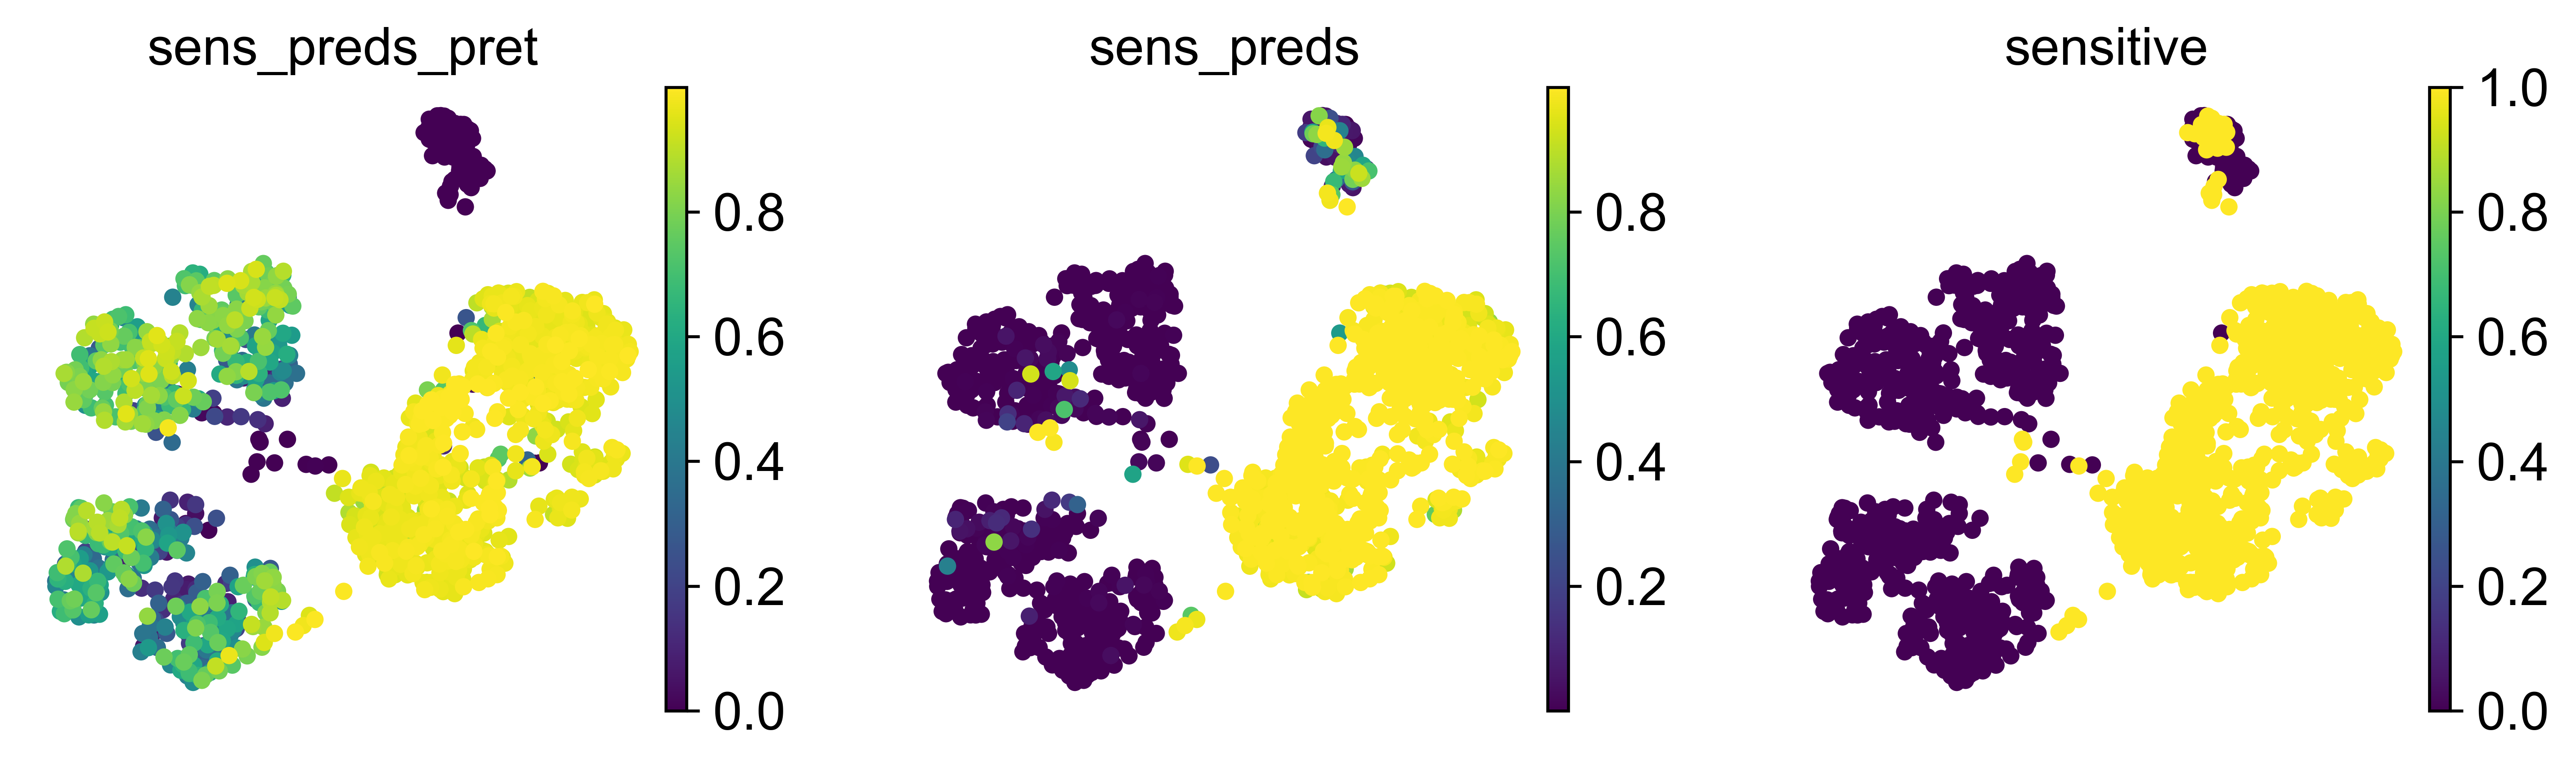

In [9]:
from sklearn.metrics import (auc, average_precision_score,
                             classification_report, mean_squared_error,
                             precision_recall_curve, r2_score, roc_auc_score)

names = []
score = []
model = []

for f in h5ad_list:
    
    
    adata = sc.read_h5ad(filename=f)
    pretrain_label = adata.obs['sens_label_pret']
    sens_label = adata.obs['sens_label']
    
        
    print(adata.obs.columns)

    grouth_truth = adata.obs['sensitive']
    sens_pb_pret = adata.obs['sens_preds_pret']
    sens_label_pret = adata.obs['sens_label_pret']
    sens_pb = adata.obs['sens_preds']

    name = f.split("1214")[0].split("\\")[1]
    
    if(name=="GSE110894"):
        adata=adata[(adata.obs["Sample name"] != "EMPTY") & \
                    (adata.obs["Sample name"] != "EMPTY ") ,: ]
    
    
    
    report_dict_pret = classification_report(grouth_truth, pretrain_label, output_dict=True)
    classification_report_pret_df = pd.DataFrame(report_dict_pret).T
    f1score_pret = report_dict_pret['weighted avg']['f1-score']
    ap_pret = average_precision_score(grouth_truth, sens_pb_pret)
    auroc_pret = roc_auc_score(grouth_truth, sens_label_pret)

    
    report_dict = classification_report(grouth_truth, sens_label, output_dict=True)
    classification_report_df = pd.DataFrame(report_dict).T
    f1score = report_dict['weighted avg']['f1-score']
    ap = average_precision_score(grouth_truth, sens_pb)
    auroc = roc_auc_score(grouth_truth, sens_label)
    
    names.append(name)
    score.append(f1score_pret)
    model.append("before")
    
    names.append(name)
    score.append(f1score)
    model.append("transfer")

    result = pd.DataFrame({"f1":[f1score_pret,f1score],
                          "ap":[ap_pret,ap],
                          "auroc":[auroc_pret,auroc]},index=["pretrain","transfer"])
    
    print()
    # Save the figure
    sc.pl.umap(adata,color=['sens_preds_pret','sens_preds','sensitive'],save="report_compare"+name + '.png')
    # Save the f1 score before and after
    result.to_csv("saved/results/report_compare"+name + '.csv')



In [10]:
result_compare = pd.DataFrame({"data":names,
                      "transfer":model,
                      "score":score})

In [11]:
adata.obs

,Plate#,Well position,Sample name,Index-Sort condition,Well index,sensitive,sensitivity,Sensitive_score,Resistant_score,n_genes,...,pct_counts_rps,total_counts_rpl,pct_counts_rpl,leiden,leiden_origin,sens_preds_pret,sens_label_pret,sens_preds,sens_label,rest_preds
RPI1_A3,RPI1,A3,MA9 IBET RESISTANT CELLS,GR+,GGTCTATG,0,Resistant,-2.726364,14.205806,7132,...,0.0,0.0,0.0,3,3,0.527935,1,0.000138,0,0.999864
RPI1_A4,RPI1,A4,MA9 IBET RESISTANT CELLS,GR+,GTCCGAAT,0,Resistant,-2.200808,10.421614,6815,...,0.0,0.0,0.0,3,3,0.676591,1,0.000264,0,0.999738
RPI1_A5,RPI1,A5,MA9 IBET RESISTANT CELLS,GR+,TAGTGCGT,0,Resistant,-1.273636,5.788548,4951,...,0.0,0.0,0.0,3,3,0.746028,1,0.006229,0,0.993606
RPI1_A6,RPI1,A6,MA9 IBET RESISTANT CELLS,GR+,GACTGTAC,0,Resistant,-3.492323,16.025484,7615,...,0.0,0.0,0.0,3,3,0.387372,0,0.000051,0,0.999950
RPI1_A7,RPI1,A7,MA9 IBET RESISTANT CELLS,GR+,TCCAGTAG,0,Resistant,-2.236667,13.070160,6688,...,0.0,0.0,0.0,3,3,0.493321,0,0.000098,0,0.999904
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RPI7_P17,RPI7,P17,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,GTCACGTA,0,Resistant,-1.414444,7.688226,5183,...,0.0,0.0,0.0,1,1,0.104751,0,0.000162,0,0.999839
RPI7_P18,RPI7,P18,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,ACGTGTGT,0,Resistant,-1.348788,8.079032,5421,...,0.0,0.0,0.0,1,1,0.476262,0,0.001626,0,0.998354
RPI7_P19,RPI7,P19,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,TCAGCGTA,0,Resistant,-1.234040,8.462097,5293,...,0.0,0.0,0.0,1,1,0.315842,0,0.000260,0,0.999741
RPI7_P20,RPI7,P20,MA9 IBET RESISTANT CELLS- WITHDRAWAL,GR-,AGAAGAGG,0,Resistant,-0.823939,5.184032,4101,...,0.0,0.0,0.0,1,1,0.086513,0,0.006288,0,0.993544


# Plot the umap highlighting the wrong predictions

In [12]:
idx = adata.obs["sensitive"] != adata.obs["sens_label"]

In [13]:
adata.obs['wrong'] = pd.NA

Trying to set attribute `.obs` of view, copying.


In [14]:
adata.obs.loc[idx,'wrong'] = "Wrong"
adata.obs['wrong'] = adata.obs.wrong.astype('category')

In [15]:
#sc.pl.umap(adata,color=['ABCC2', 'BIRC3', 'CCND1', 'CFLAR', 'CHEK2', 'ERCC1', 'MT2A', 'POLB', 'GCLC','GSTT2','TP53','MDM2','RAC1'],size=20)

In [ ]:
sc.pl.umap(adata,color="wrong",size=20)

In [16]:
df = adata.obs[[CELL_TYPE_KEY[name],"wrong"]]\
.groupby([CELL_TYPE_KEY[name]])\
.aggregate(['count','size'])\
.reset_index()
df['data'] = name
df

Sample name wrong            data
                                        count size           
0                      101 CELL CONTROL     3    4  GSE110894
1              MA9 IBET RESISTANT CELLS    15  345  GSE110894
2  MA9 IBET RESISTANT CELLS- WITHDRAWAL     9  340  GSE110894
3                    MA9 PARENTALS DMSO    10  372  GSE110894
4            MA9 PARENTALS IBET 400NMOL     8  343  GSE110894

In [17]:
result_compare

,data,transfer,score
0,GSE110894,before,0.649327
1,GSE110894,transfer,0.961950


# Barplot of score before and after the transfer

[None, None]

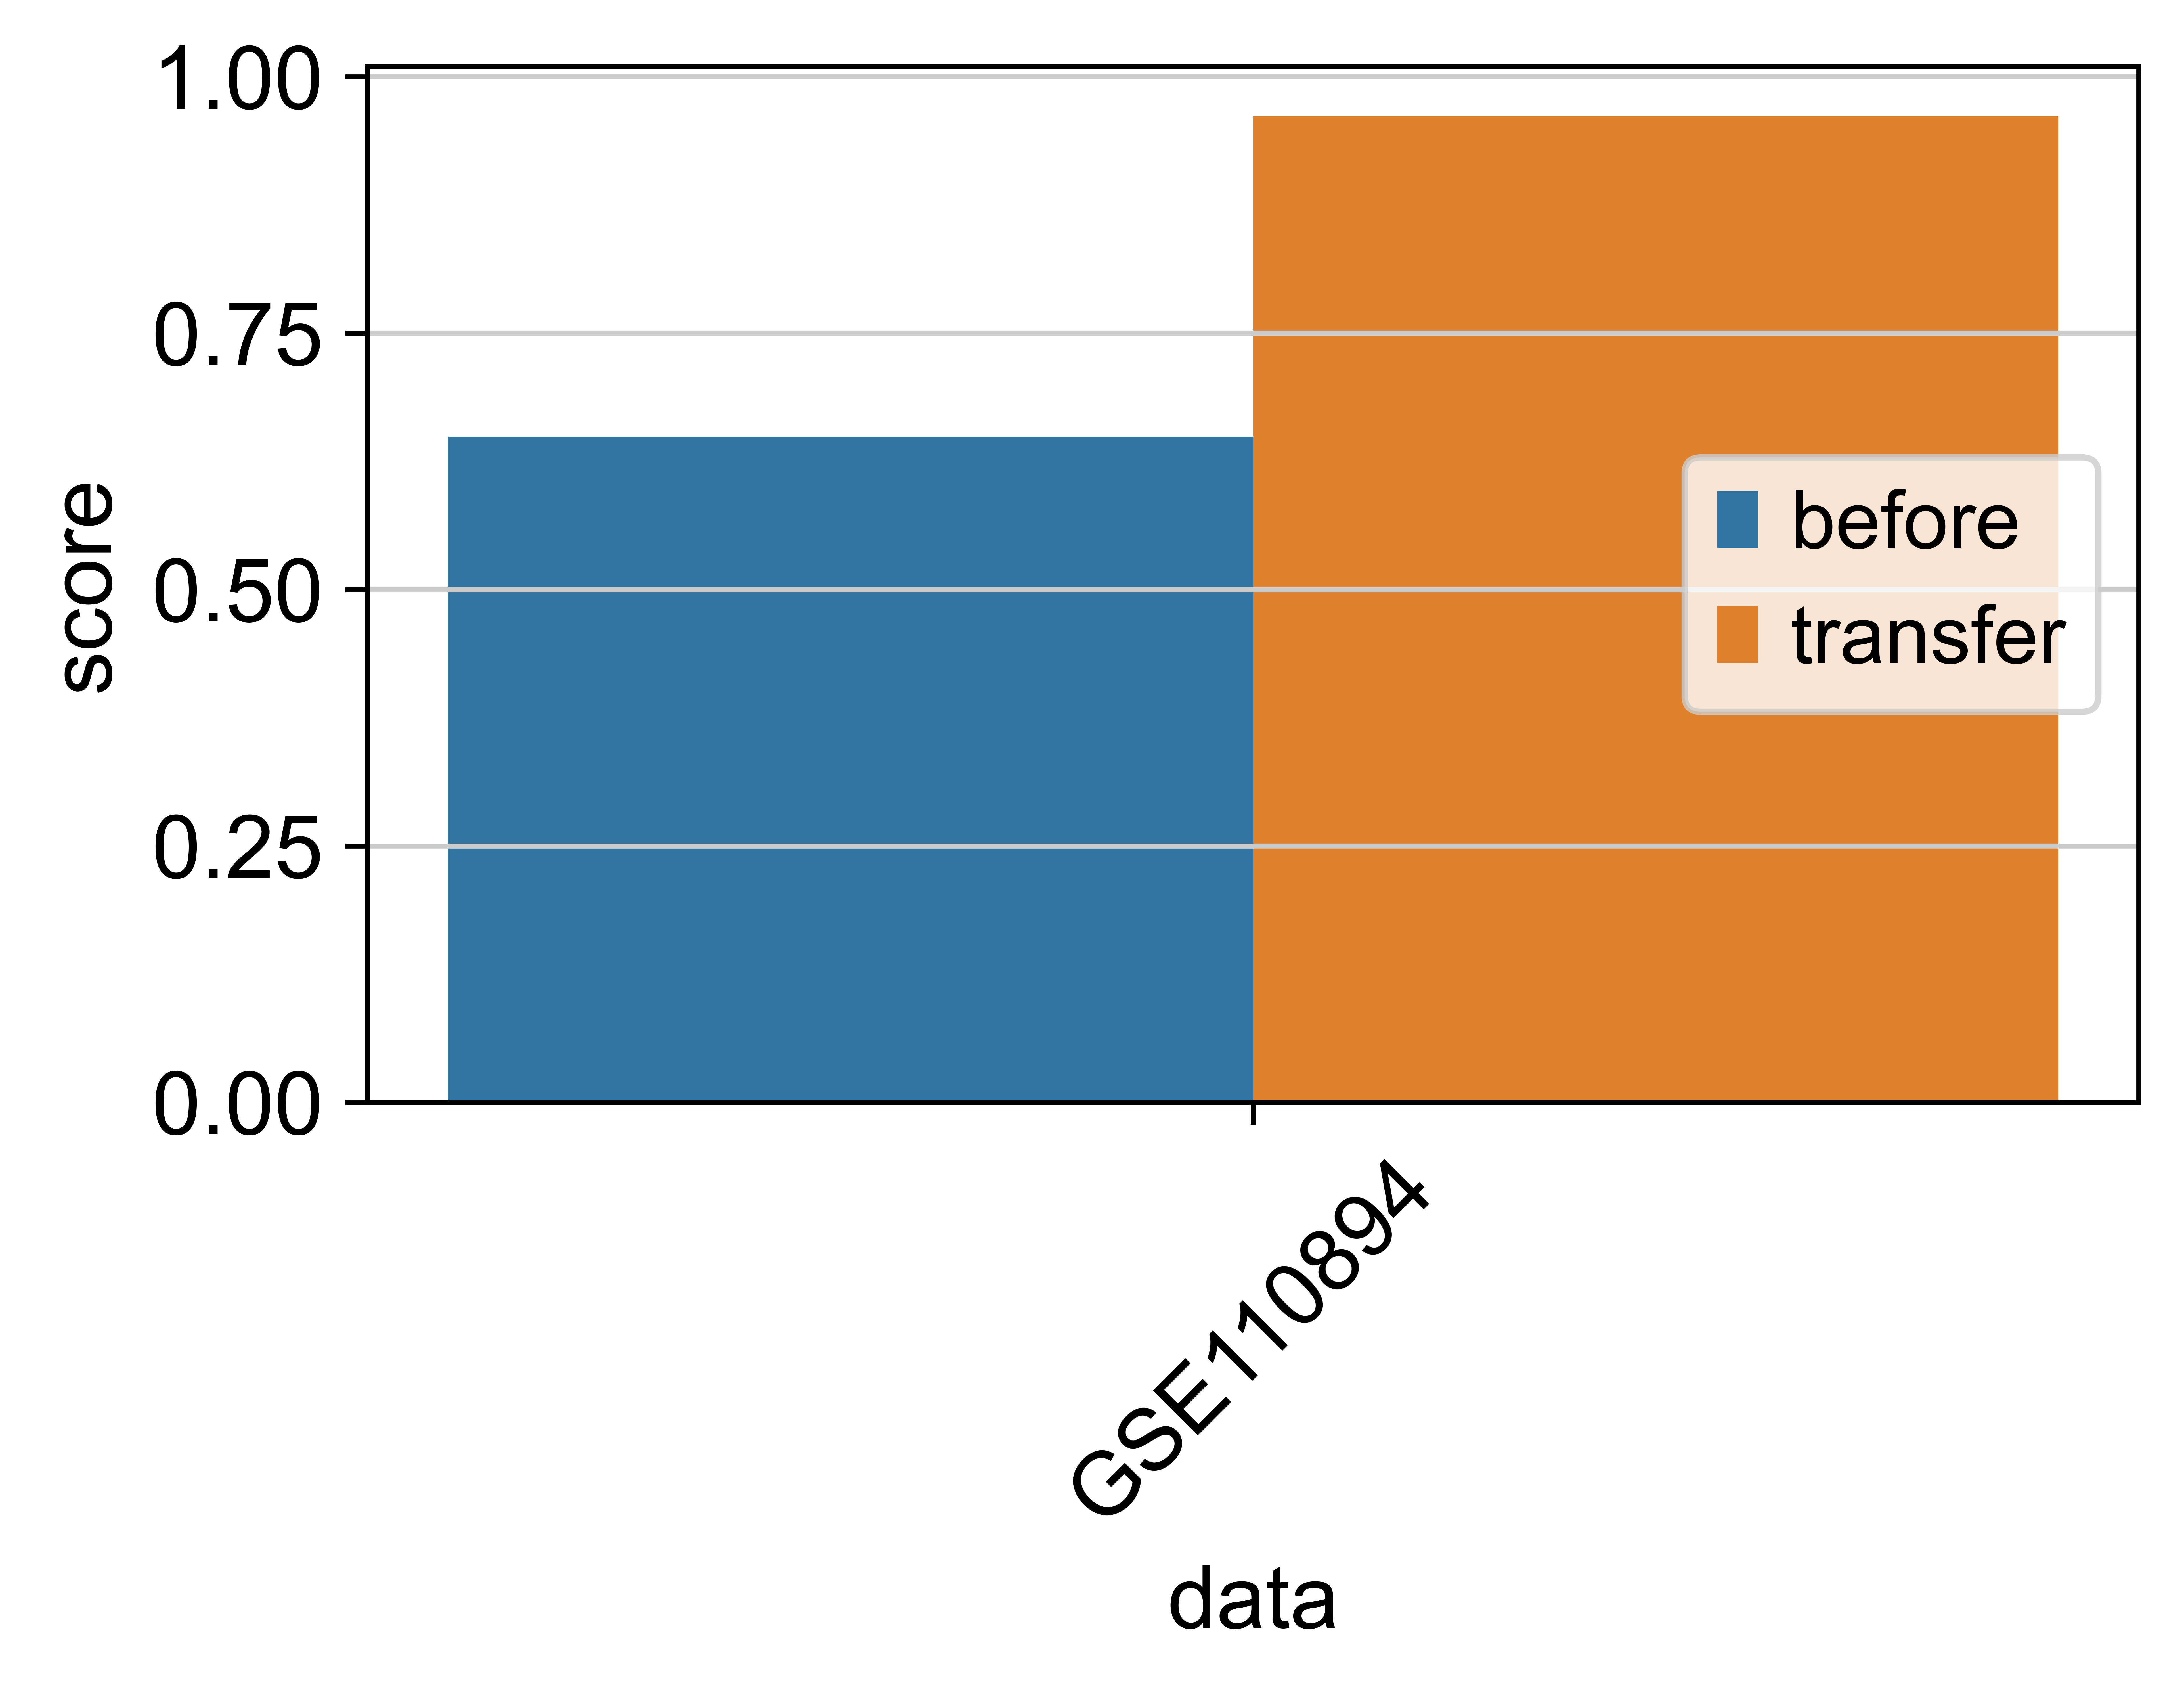

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

sc.settings.set_figure_params(dpi=800, frameon=False, figsize=(5, 3), facecolor='white')  # low dpi (dots per inch) yields small inline figures
g = sns.barplot(x="data", y="score",hue="transfer",
                data=result_compare)
plt.legend(loc='right')

plt.setp(g.get_xticklabels(), rotation=45)

# Figure 2 A panel

In [19]:
adata.obs.sens_label = adata.obs.sens_label.cat.rename_categories({1:"Response", 0:"Resistant"})

In [20]:
adata.obs.sensitivity = adata.obs.sensitivity.cat.rename_categories({"Sensitive":"Response", "Resistant":"Resistant"})

In [40]:
ax

In [44]:
ax

In [21]:
adata.obs=adata.obs.rename(columns={"sensitivity": "Ground Truth", "sens_label": "Prediction"})

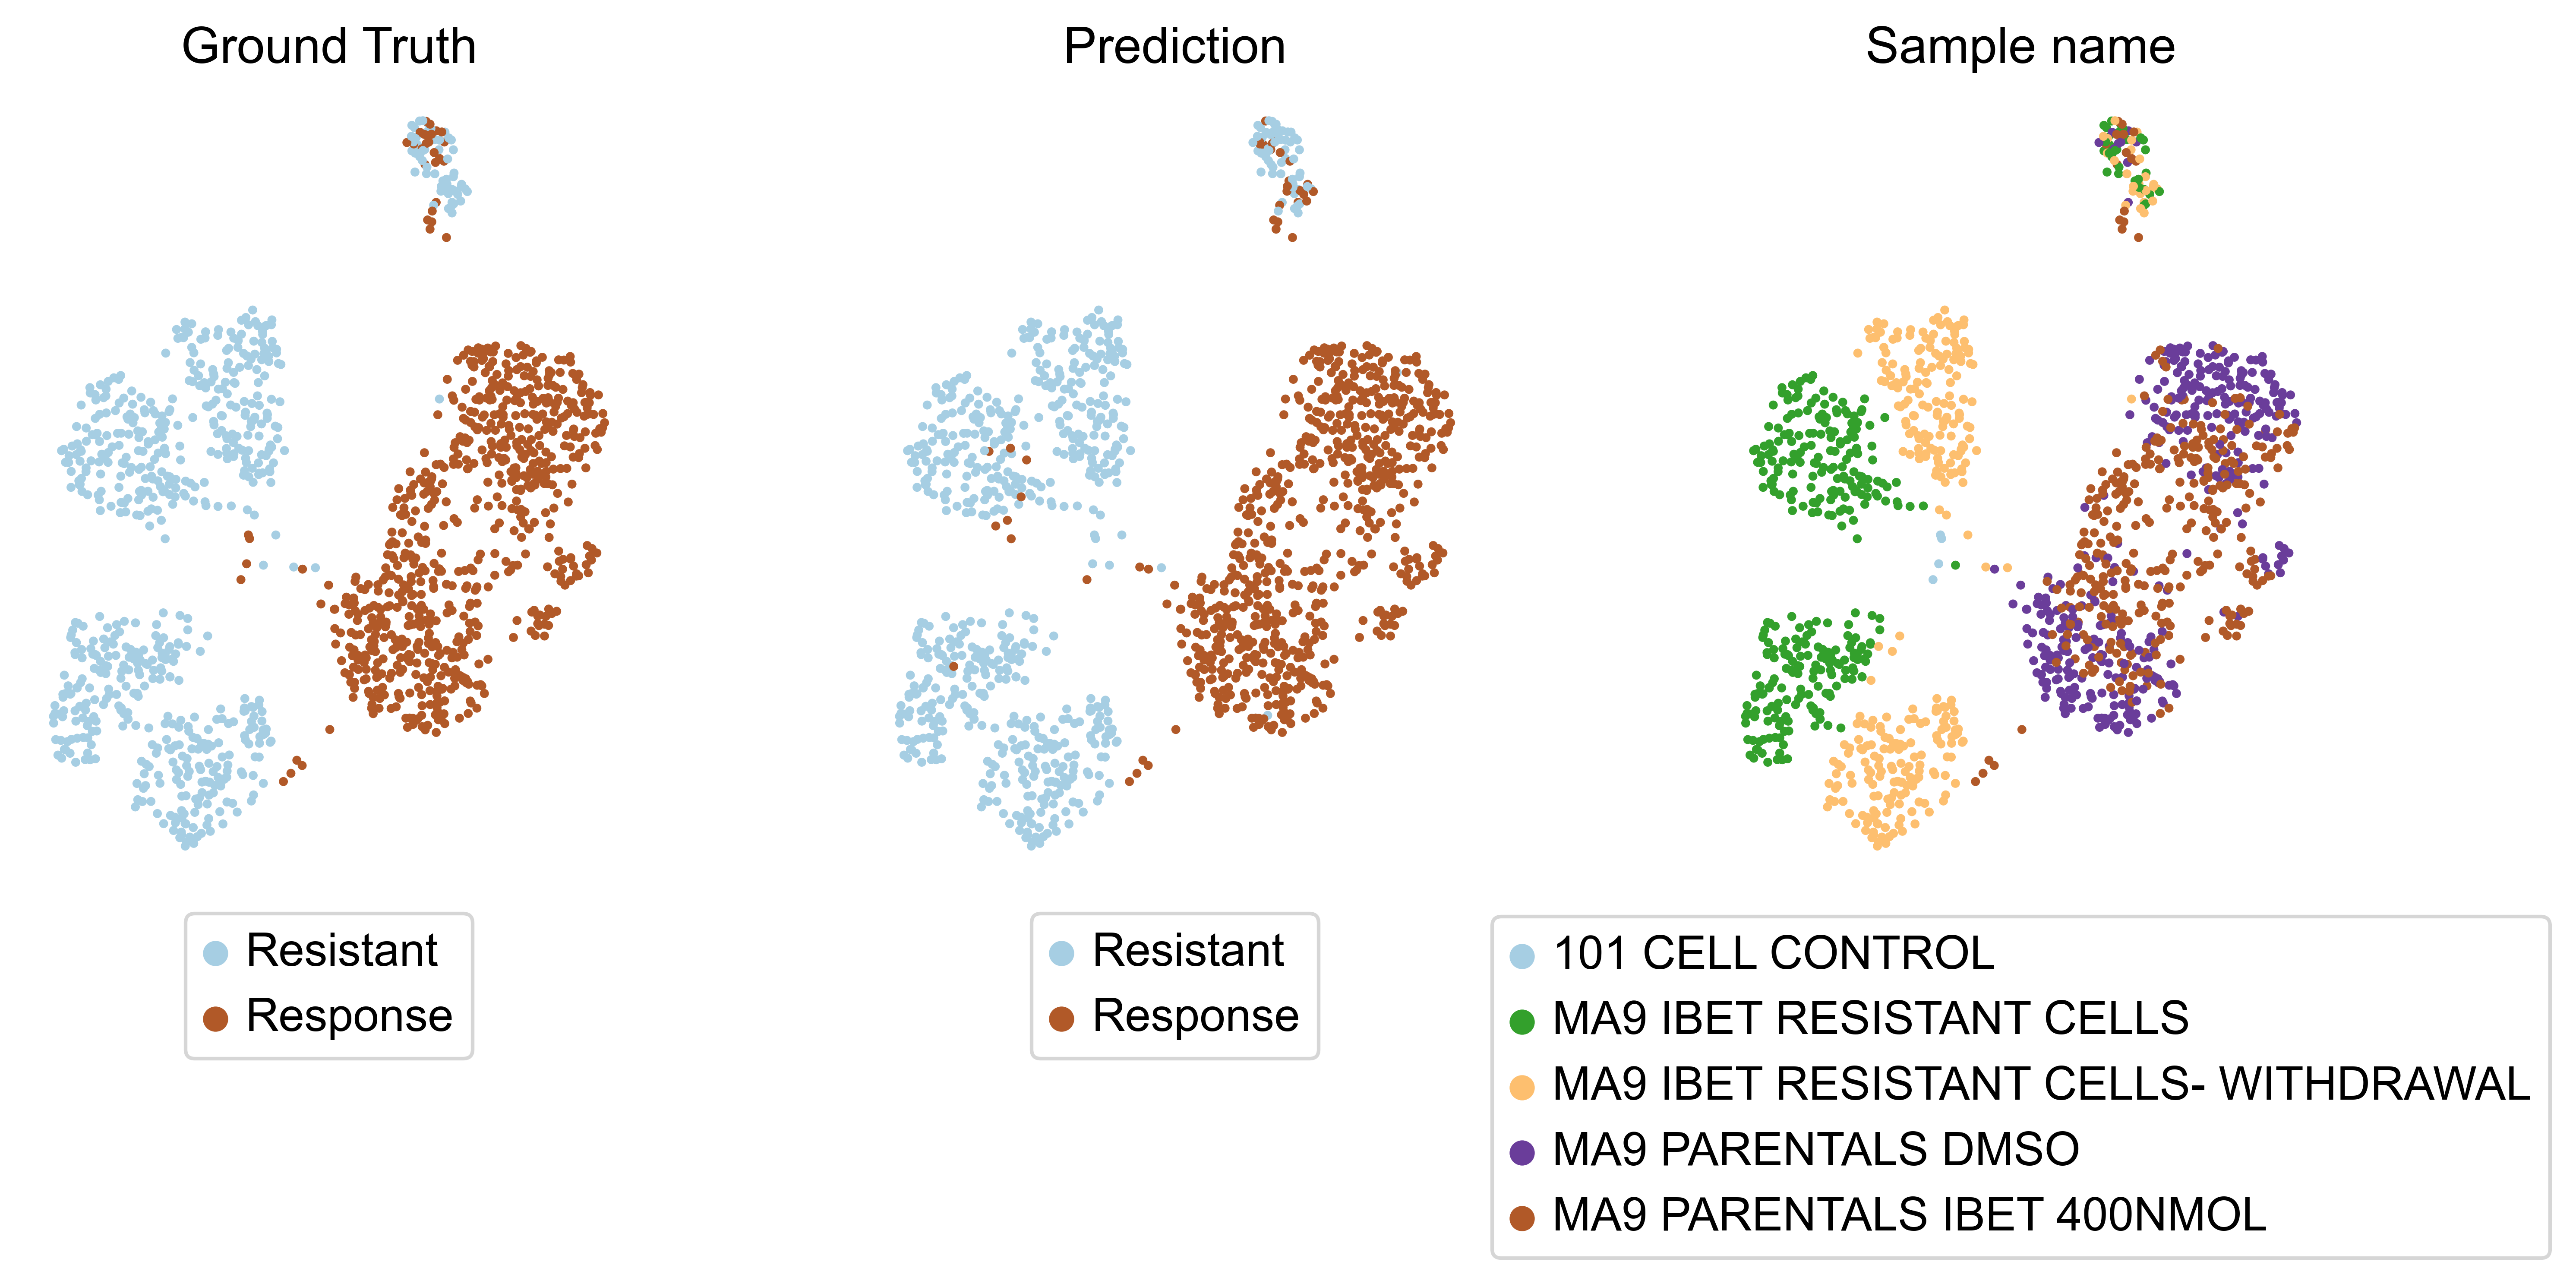

In [61]:
sc.settings.set_figure_params(dpi=300, frameon=False, figsize=(3, 4), facecolor='white')  # low dpi (dots per inch) yields small inline figures
ax = sc.pl.umap(adata,color=['Ground Truth',"Prediction",CELL_TYPE_KEY[name]],size=25,palette="Paired",show=False)
ax[0].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[1].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.25)) 
ax[2].legend(loc ='lower center',bbox_to_anchor=(0.5, -0.5)) 